In [18]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import cv2
import IPython.display as ipd
import ipywidgets as widgets

In [19]:
#load data (change if "data" folder is not in the same folder as this file)
path_to_data = 'C:\\Users\\Josua Graf\\polybox\\Neural Systems\\b8p2male-b10o15female_aligned(1)\\b8p2male-b10o15female_aligned'


In [20]:
def classify(filename, start, stop, window_length=10240, hop_length=2560):
    """
    Returns frames classified into S_trivial_m, S_trivial_f and S_clean

    Parameter:
    ----------
    :param filename: file URL (xx_SdrChannels)
    :param start: start of audio (in seconds; 0 for minimum)
    :param stop: stop of audio (in seconds; -1 for maximum)
    :param window_length: frame length
    :param hop_length: overlap of frames (ideally: window_length / int)
    :return: (S_trivial_m, S_trivial_f, S_clean), with each of the form: [[y, y_f, y_m],...,[y', y_f', y_m']],
        where y = mic, y_f = female acc, y_m = male_acc are amplitude values of one vocalization frame
    """

    # Import audio -----------------------------------------------------------------------------------------------------
    sampling_rate = 24000

    start = start * sampling_rate
    stop = stop * sampling_rate if stop > 0 else -1

    audio, sampling_rate = sf.read(filename, start=start, stop=stop)

    lim = math.floor(len(audio) / window_length) * window_length    # ensures full "framization" of sequence
    channels = {
        "mic": audio[:lim, 0],
        "female": audio[:lim, 1],
        "male": audio[:lim, 2]
    }

    mic = channels["mic"]
    female = channels["female"]
    male = channels["male"]
    time = np.arange(len(mic)) / sampling_rate    # in seconds

    # Local Regression (eliminate offset) ------------------------------------------------------------------------------
    signal = []
    length = 10000  # interpolation frame length
    model = LinearRegression()
    transformer = PolynomialFeatures(3)     # polynomial interpolation of order 3
    for i in range(0, len(mic), length):
        t = time[i:i + length]
        X = transformer.fit_transform(t.reshape(-1, 1))
        y = mic[i:i + length]
        model.fit(X, y)
        signal.append(model.predict(X))
    mic = mic - [item for items in signal for item in items]

    # Features ---------------------------------------------------------------------------------------------------------
    energy = 200 * librosa.feature.rms(np.asfortranarray(mic), center=False,
                                       frame_length=window_length, hop_length=hop_length)[0] ** 2

    # Signal detection  ------------------------------------------------------------------------------------------------
    frames = [[i, i + window_length] for i in range(0, len(mic) - window_length + 1, hop_length)]
    labels = ["" for i in range(len(energy))]   # class of each frame

    threshold_silence = 0.005
    threshold_signal_lower = 0.07
    threshold_signal_upper = 0.3
    for i, value in enumerate(energy):
        if value < threshold_silence:
            labels[i] = "silence"
        elif threshold_signal_lower < value < threshold_signal_upper:
            labels[i] = "signal"
        else:
            labels[i] = "not classified"

    samples = {}    # samples[index of audio file] = corresponding class
    for label in ["not classified", "silence", "signal"]:
        for i, frame in enumerate(frames):
            if labels[i] == label:
                for t in range(frame[0], frame[1]):
                    samples[t] = label

    # Reorder frames (connect overlapping frames) ----------------------------------------------------------------------
    signal = []
    frame = []
    for t in sorted(samples.keys()):
        label = samples[t]
        if label == "signal":
            frame.append(t)
        else:
            signal.append(frame) if len(frame) != 0 else None
            frame = []

    # Clustering -------------------------------------------------------------------------------------------------------
    sr = sampling_rate
    
    def radio(m, f): 
        spec_flatness_f = 100 * np.average(librosa.feature.spectral_flatness(np.asfortranarray(f))) # percentage
        spec_flatness_m = 100 * np.average(librosa.feature.spectral_flatness(np.asfortranarray(m))) # percentage
        
        return True if (spec_flatness_m > 30 or spec_flatness_f > 30) else False # only filters out radio noise
    
    def vocalizer(m, f):
        # mel
        S = librosa.feature.melspectrogram(y=np.asfortranarray(m), sr=sr, n_mels=64, fmin=300, fmax=2000)
        m = librosa.power_to_db(S, ref=np.max)

        S = librosa.feature.melspectrogram(y=np.asfortranarray(f), sr=sr, n_mels=64, fmin=0, fmax=3000)
        f = librosa.power_to_db(S, ref=np.max)

        # image analysis
        img_m = np.asarray(m, dtype=np.uint8)
        img_f = np.asarray(f, dtype=np.uint8)

        # yellow analysis (spectral energy in freq interval)
        yellow = np.average([np.average(list) for list in img_m])
        voc_m = 210 < np.average([np.average(list) for list in img_m]) < 250
        voc_f = 210 < np.average([np.average(list) for list in img_f]) < 250

        # spectral complexity analysis
        a, b = np.shape(img_m) # same for img_f
        imgs = [img_m, img_f]
        perimeters = [0, 0]

        for j, img in enumerate(imgs):
            # accentuate complexity
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            ret, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
            img = cv2.GaussianBlur(img, (7,7), 0)
            ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
            img = cv2.Canny(img, 100, 200)

            perimeter = np.count_nonzero(img != 0)
            perimeters[j] = 100 * perimeter / (2 * (a + b))

        voc_m = (perimeters[0] > 90) and voc_m
        voc_f = (perimeters[1] > 90) and voc_f
    
        return voc_m, voc_f
    
    S_trivial_m = []    # only male vocalizes
    S_trivial_f = []    # only female vocalizes
    S_clean = []        # both vocalize
    
    for frame in signal:
        t = np.asarray(frame)
        y, y_f, y_m = [mic[x] for x in t], [female[x] for x in t], [male[x] for x in t]
        
        if not radio(y_m, y_f): # make sure has no noise
            m_, f_ = vocalizer(y_m, y_f)
            if m_ and f_:
                S_clean.append([y, y_f, y_m]) # both
            elif m_:
                S_trivial_m.append([y, y_f, y_m]) # only male
            elif f_:
                S_trivial_f.append([y, y_f, y_m]) # only female
            else:
                None    # none
    
    return S_trivial_m, S_trivial_f, S_clean

In [21]:
# USER:
number = 53
filename = path_to_data +\
           "/2018-08-19/b8p2male-b10o15female_" + str(number) + "_SdrChannels.w64"
S_trivial_m, S_trivial_f, S_clean = classify(filename, 0, -1)

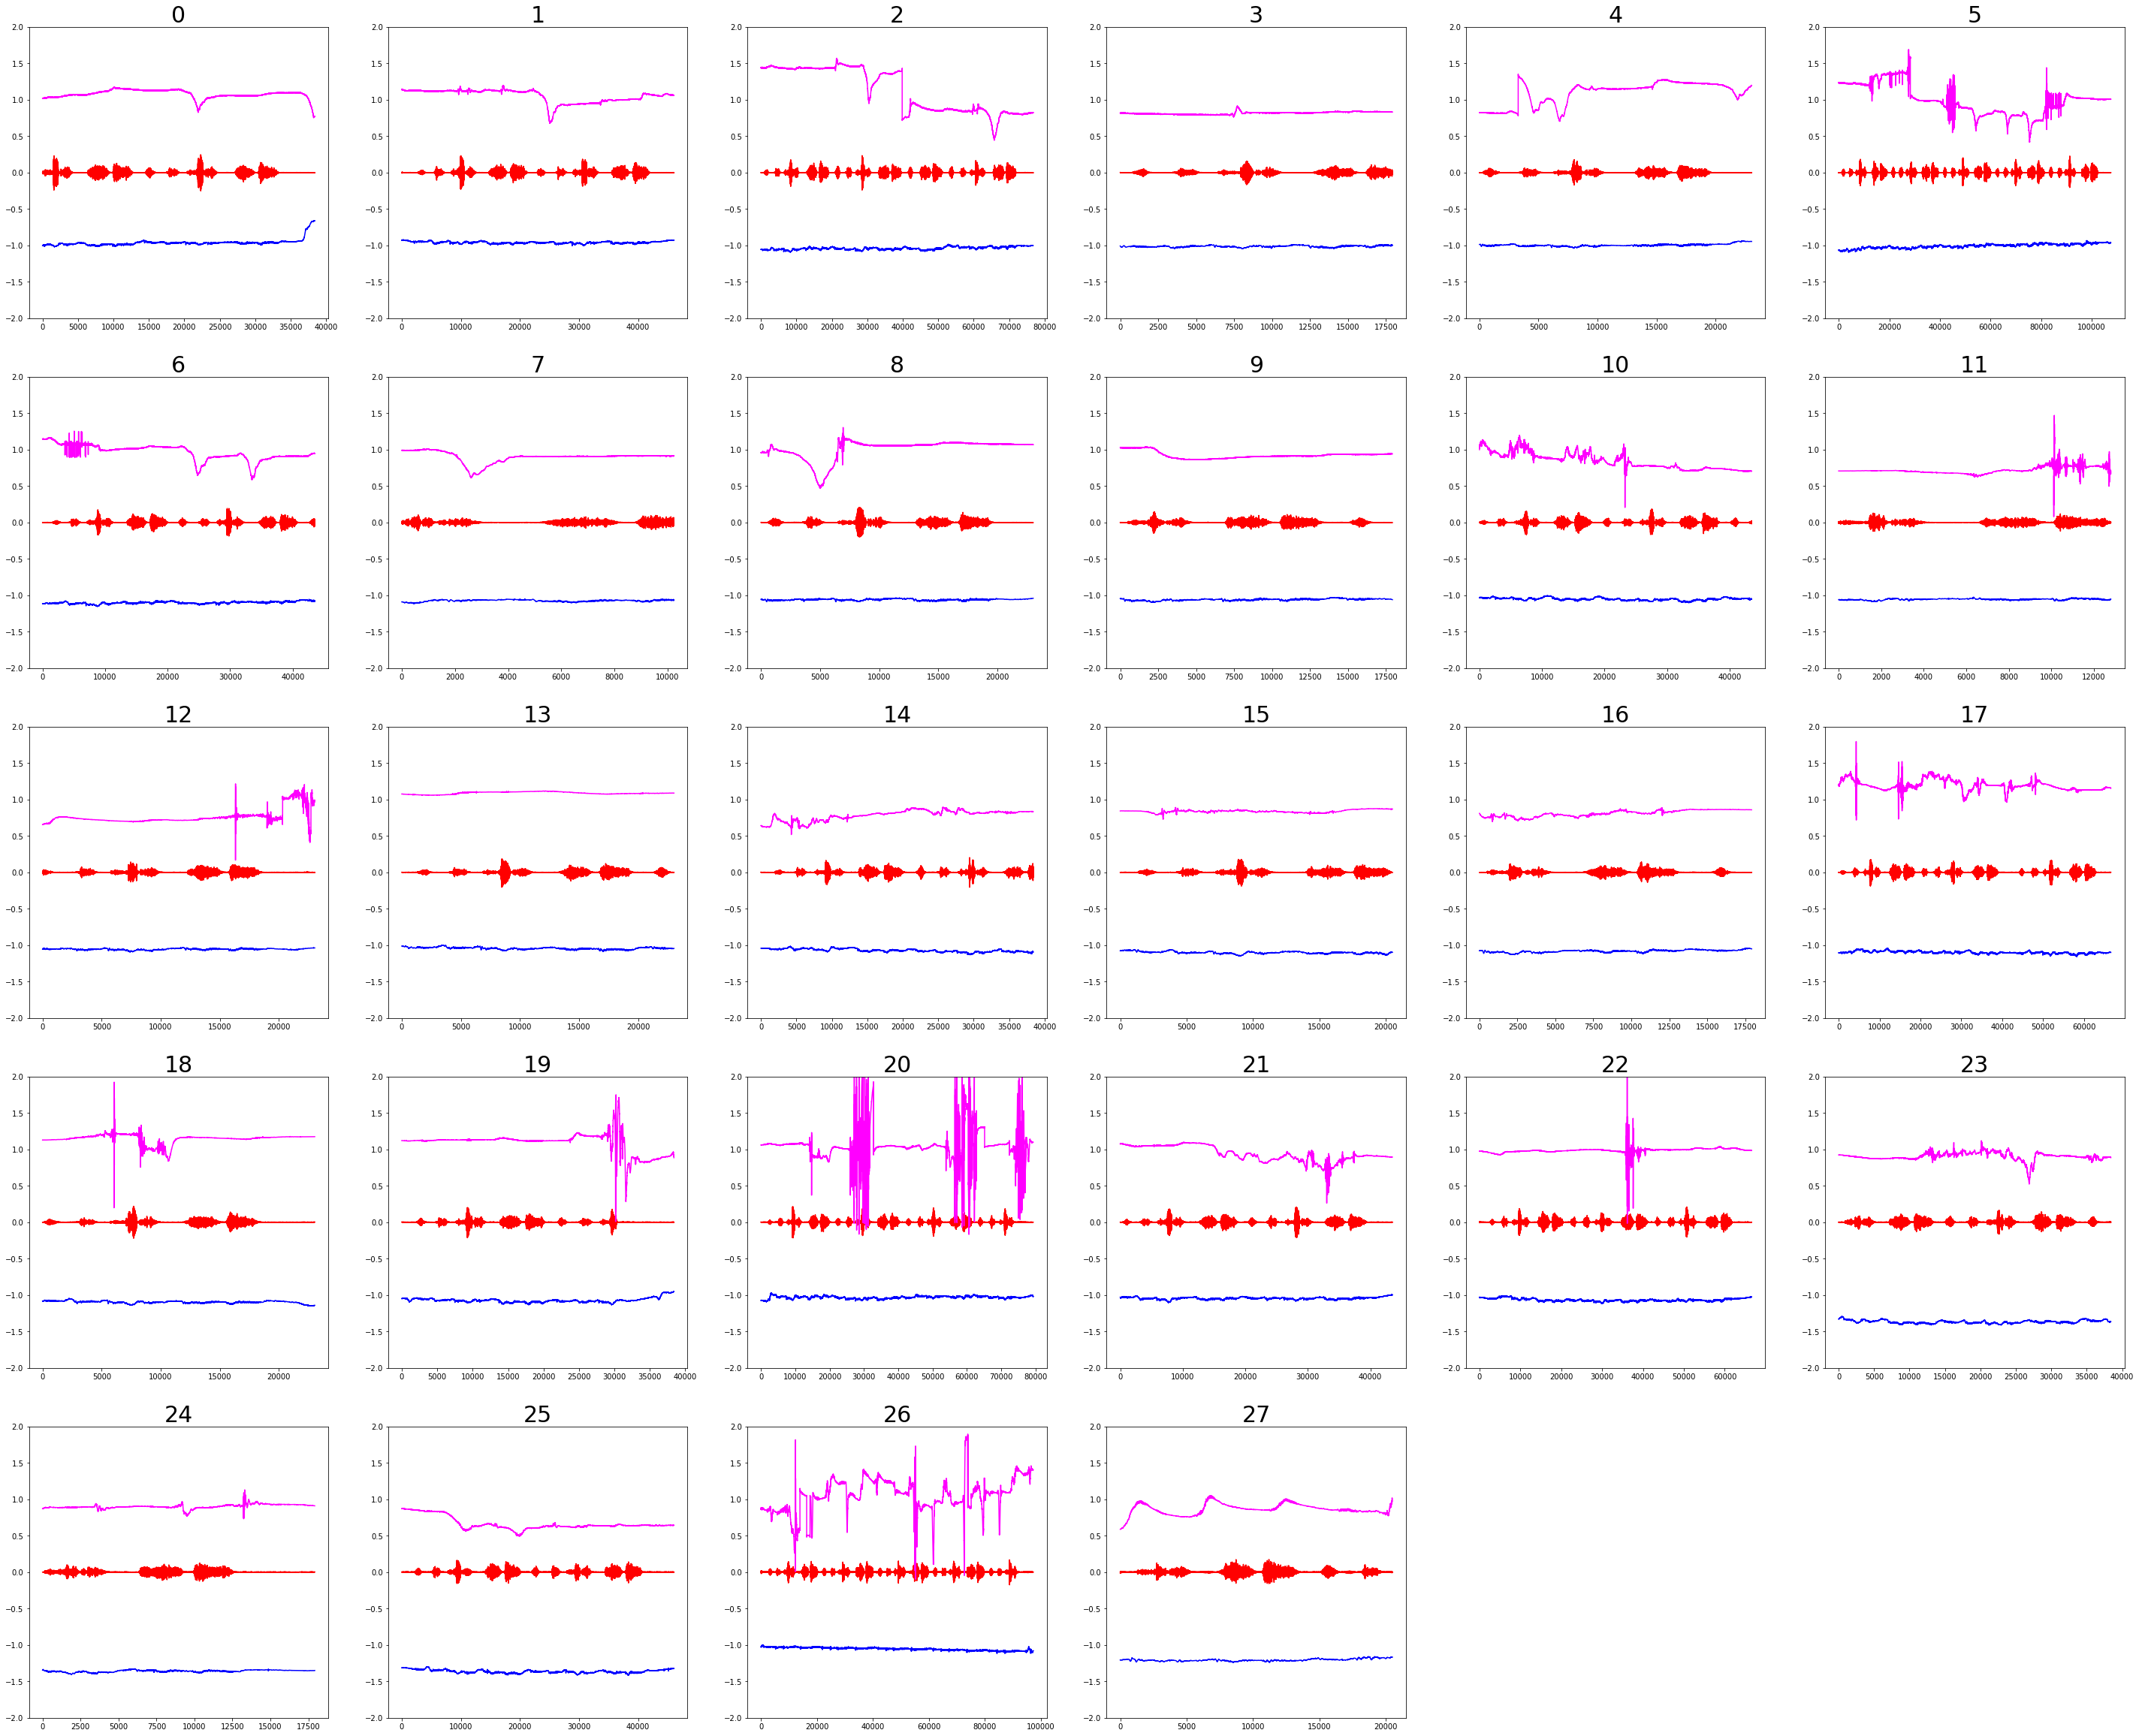

In [27]:
# Plot S_trivial_m
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_trivial_m])))
for i, frame in enumerate(S_trivial_m):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

In [29]:
# Plot S_trivial_f
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_trivial_f])))
for i, frame in enumerate(S_trivial_f):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

<Figure size 3600x3600 with 0 Axes>

In [30]:
# Plot S_clean
plt.figure(figsize=(50, 50))
n = math.ceil(np.sqrt(len([0 for frame in S_clean])))
for i, frame in enumerate(S_clean):
    mic = frame[0]
    female = [value + 1 for value in frame[1]]
    male = [value - 1 for value in frame[2]]

    ax = plt.subplot(n, n, i + 1)
    plt.ylim(-2, 2)
    plt.title(i, fontsize=30)
    plt.plot(mic, "red")
    # female
    plt.plot(female, "magenta")
    # male
    plt.plot(male, "blue")
plt.show()

<Figure size 3600x3600 with 0 Axes>

In [44]:
# Choose frame in S_trivial_m
signal = S_trivial_m
print("n_signals: ", len([0 for frame in signal]))

play_frame = 2
dropdown = widgets.Dropdown(options=[(str(i), i) for i in range(len(signal))], values=2, description="Frame:")
display(dropdown)

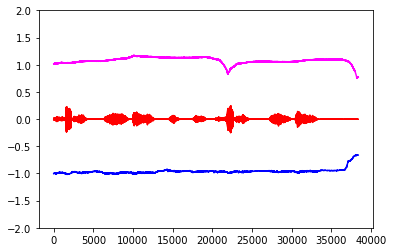

mic


<audio  controls="controls" >
                    <source src="data:audio/wav;base64,UklGRiQsAQBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0YQAsAQDCAeoBU/71+zj+RQNLBWICXf4T/I78Df/PAFsDpwPcAQT/kvx9/Aj+HwKaBhMFhP8K/d/97P44/b79agM7CHMF2/wE99T5igKsB10GYwFa/En8k/+jALL+7v/BBPYDGwBl/fL5dPlPAFAJugmcAIX5ZfpI/YAAHAPSBTwEJ/47/O/8xP0PABsFdgWlAOX9KP6j/ET5rP+RCcgI1/8I+Qb72/4BAMcCywW2A5H83fsU/9b+dv9tA9cF6QBM/tIAHf/2+Yb6bgKMClkHL/zC9wH71wDcBcwEfwBV/kP9WP5lAPn9vf6wBG4EX/46/BL+SP7K/zkDeAEY/rIAGgPm+9X2wwJFCfn/APqB/YcCYgEK/20A+/7m/VsDSQX2/hL6Q/04AsgCJf97/jEDIwRw/ar4bv7JBGYCzP4N/2z+nv1r//z/Ff/fAJECpwFY/pL80P1S/cIAtwTuAIT+NABt/oz7Q/1GBKkFF/5S+/r96ADUAbr/8P1VAOwB1QDx/gr+NgCYAuYAy/v/+wgEegeT/Wn6iAHpAdP8Sv4IA0ABOP78/nsA9P32/YUDsgI7/Pn7fgAoAvMAtP4S/bH+HAJ3AkYAIv+//0T/1vt6/kUG6wLO/KH/av6Q/HcBYwKJ/2L+zf9z/78AbAAv++L8GQQSBcH83PqOAKUC5/+w/48CSv71+HkENQmc+ZX7jwZj/8r65QKKBEP7jftCB64CMvhDAeYFFvwA/TwCEwDN//L/xPjKALEKvfht+WsNGQEA9eADsAf6+mz5sAQVBUL9/P3SAEb+sf/yBOoAmvuMAAsFQPkW+pQN0f/C87MLhQVq7/MC4w149Zr4Qw5sATzxWwGBDG34rflKDCH+EvWAB4AG4fYy/okH+vws+hsFcgKD9Az6UA52/u3sDA73DUPpEADJE4L2y/OlCb8Iovaa+oQIjvji9KcOFggh71P+aQ+z+tn2+wozAuDzPwEMCZ386vskAZT4kQB0DFL8BfhNCuH/evULCAYInPns/nYFyvy1+e0C9wDI+goFxwRB+eL/+Ab2/CH81gb6/uD2dQExBUMBwvx9/Oz/qQDGAQYA6wAuBXD6b/v5BzYDLfxp+QAA4Abi/Gz6swbV/n/3bgavAyL36QBcBf776AEvAy/0NQCjDqv3YPPxEVMINukxANkUSPek8nIPZQYV7jH9XQ1W/Q74kQbGA4759P9gAgj8ZP+TBSMBa/sH/7ACswGt/x797v2qBAEENfoF/FIJ0AZJ8wf4rQ4xCPjxUPvDDvL+VvPeBRAH0fZ5/IoL6wRH+Gr7uQMSBD//x/0RALIAZQCMAgAAofiX/mkKzwNa9nX4dwpcDL3zG/FNDLgQIfZU8rII4gdC9h/6kgm+Aw33ev7DCFwAnfe3/RAGPwQw/LX5SQDjBB7/pfne/n0E+QK+/h36mf2MCjEHD/H18oENEBCd9uLwAwUJCEj6T/qXAqMBKv1yAMkEjP8d92P8fQhfBoL4YvY5A8AHpfwU9zb/xwXPAo76rPoiA/gGaACP9en34wimDGX72vL9/lYHlv+g+Tv8FwIeBdcCVP/d+xb8MAD/BQgEOPoT+WID6gcP/mD1YfygB3AFgv21/V0CagXTABX3MvtaCMMI1P3z9nL7CgMNBHr78PUZBLkO5AP19sT3vwGGB6AFQv5E+Sf8ZQVaB0b97vL29qELnhC2/Yf1wP8HB1MAnvhG/VMGeQTU/B78sP3v/QEAPQMKAqL/JgBkADX9eftH/4sENQSD/Zj5yP0ZA+sBDfzN+P0BggglAt77vvtpAV8ENf+e/MECVAPg/r7/kv7T/EP/8QEDBDIBIv07AZ4FPwEu/MMAegUnAG78WgA2BKEDTAAn+Bn38ATAC5wEjP0b+wX+lAS5AyX/If+SAfUBDv/2/Cj+1Pwc/QAEewecAif8h/vr/jQEMQWy/7n8V/0JAAIDBgLR/rn3aPfeBqIRuATJ8+L0XgDGB+sFCwHS/T7+M/+r/oT+8/6C/moAowR0Avn7bfsJANMDfwQ3AUT8G/xOAMoCEwIH/5D8dfzm+tn/1QmtBi38rvhh/iYFCAasAHj7Zvwx/wUD/gOm/8j7BPxt/5QAUwBqAdcDbAO5AGT81vrm/lcDwgQNAmT8BvsB/0/94fqAAO8HFQZn/pb5CvzfAbADsQBS/kT+Pv+XAdD/uPy1/Jn+ggGgAeb+w/+NAh4Ci/5H/Ev/VAOhAwgAePyn/Dr/K/5H/CMBWweXBpz+V/j5+i0CMgVgA4D+y/t4AFYDVf9v+oL5p/4/Br4GwP9Q+/78MACnAA0ATADZAVUC0gAI/sv8If1t+oj95AV+CXwGtfsQ8yD4GARTC0kHPfxE9yz8zQO3BLT+8PjN+9MD0AZhA9n8xfmT/MUBSwUBBOcAnP6N/fr9HgD2Adb7jvjqA20NgAkY/jLzLPUJA1ENvwoo/wr3WPmCAZ8FvwFN+637+wL5BWACDv85/Zf9EQA2AqQCSQFQABgAAACF/8D/jPyM9Yf9mg30DggD8fX+8Bb7fwlGC+wDiPoN+Mb+KgTqAnf+g/pb/AQCJwNpAdX/+v3b/ef9F//YANoAogCi/2n+Pf4G/2n6p/WMAWsPdgpT/E3ytvQlARsLfwip/3z5z/pBAl8DCADP+2b6lP+/BB8EaQE6/yf+2/2y/u8BkgNrAwoBFf2p+3/98QAQ/cH3/AMKDrQGe/v+9PD5FwamCyAFy/kg9HP6YQWnCHcCZvmJ+GIAogYTBeH/6fwH/hQBfwKsAsAAUP+T/if+CQCEAR36tPVQBIsRLwwW/QXzkPpYBv0IbAME+FL19/2UB7kHsf/T9wD5dAQVCEIBQf2e/hYBQABk/qb9FP9eAqADWwCG/aL82vVX+q8MgRE4Bsz2jfMl//0HAAcp/of2RvrPBNMHgAEn+vr25QAhDbgJlPzW9Wf9twXLA7f9HfpV/uIE2gO6/ff76/+A+pv1YAjuE98EgPN48Sn/YArTBzr7lvTw+xwGcgbE/OL2Ovq+BB8MpQTs95f2WgAgB+gDhvxg+vD+XgPxAoH/C/6JAKP/cfsj+6kC+AtqBDH3fvb8AOgKaAVD+CH12v33BX0Ft/1X+bf/MAUuAdT8of37/3cB1wDp/oL63fyoB98Hzv36+NH9vwKfAYr+Xv3pAT4GIwMw+5bzivlzCfoNLgJP9xD5DwKUBVT/6Ps6AA0FLQXz/4H7OPyD/04CQQJI/jn8CgIGBRIAfP1QANkCTQCL/T79CwAfAzcBe/75/ewBgwa5AbL6uPpHAcIFZQScAKb5BvquBdUG1P2l/SECvgN5/6z7Sf56Ai4A+/sJ/iEDawWNAPb76f2mAk0Dy/79+uX7AgGgB1cHg/0K+bj+5gTw/g73IP2dBngHaQDX+j39tAKmAiD/iv7P/8v/hPw6/BEEgwVX/o79DADh/tr9wf9ZBNsEQ/3T+TYA+AKC/jj7Nf4jB9wJpf0N997/WAMN/kv8HgOJCZ4Egvsp97b6RwTICB4B+/lEAGsG1wD4+uH8kQL3BU8Exfsc92r+uQM2AMz9ugCLB10Gn/rS9Y/6pwJjCeAGBPt39pT9wgPxAn/+Tvzv/qAFuQUG/IT2yvtWBeYJMQK69uP4pQIHBtMBdPx7/Ub8jPiTAKoLXQiV/fXySPZhCIkNHgPT9kz1Y/9iBwIFeP3C+Rb9kAL2A/v95/dF/W4I2Qdk/Bn4e/7YBVsDfvmp9xYD8Qc8/d/51wIOBVP+LPuc//cDCgR4AO37H/oA/bMCzwbkANf1lfpzB6UJ9wEP+WL4gv4+BcEFrf4I+aD7UAXnCBEAD/Vm+agHCgswAwX6R/cm/hsI1wnqAMf38flyAS8EWQDc/m4AOf9v/9QFvwf

In [45]:
# Listen
sampling_rate = 24000
y = signal[dropdown.value][0]
y_f = [value + 1 for value in signal[dropdown.value][1]]
y_m = [value - 1 for value in signal[dropdown.value][2]]

plt.figure()
plt.ylim(-2, 2)
plt.plot(y, "red")
# female
plt.plot(y_f, "magenta")
# male
plt.plot(y_m, "blue")
plt.show()
 
print("mic")
ipd.Audio(y, rate=sampling_rate)

In [46]:
print("female")
ipd.Audio(y_f, rate=sampling_rate)

female


<audio  controls="controls" >
                    <source src="data:audio/wav;base64,UklGRiQsAQBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0YQAsAQARbw1vA28Pb0Fv6m4ebxlvHG9Wbwlv4W44bydvMW8PbyRvEG8lbyBvE29bbyJvCW9Wbw1vNW9DbzBv+27zbnZvSG8nbzhvGW9Tb1xvIG8obypvKG+PbyhvMG94bxpvem81b1lvKm8eb3xvKW9Mb1BvS29ib2ZvbG8wb0JvfW9Wb1FvPW9bb5JvR29Nb1NvXG9Tb3VvQm9Nb49vU29Ab35vb29bb0FvnW89b2Vvhm9Zb2lvR292b1xvjW9Pb31vg29Xb0lvsW9rb0Jvk29+b15vZm9ob6FvO286b7VviG93b2Zvp29Eb4lvmW9/b3Fvhm+Db4hvr28qb8Zvk2+Gb3dvj2/Gb0Zv0G93b55vhW9Wb+Zvrm+Nb6NvrG9ub+pvpG+qb7BvtW/Ib25ve2+qb9pvs2+1b4VvzG/Vb75vgG+zb75vnW/Tb6tvm2+6b8ZvZm/wb+FvRW/lb81vnW+2b7pvpW+rb7hvwm+Nb7Rvtm+Yb71vjm/Pb3dvqm+7b39vA3CDb4hvqm9vb/VvjW9sb/NvX29SbxJwjm+4b5lvdG+2b4xvtW9sb71vlm+Xb51voW+7b4RvY29bbwtwq280b/pvYm8rb0FweW+db4tvn2+Rb3Fv0W9nb9Rvfm+ib3tvnm+tb5tvz2+Db5Jvom/eb2hvjm/Bb49v0297b7hvoG9xb+xvkW/0b4Zvo2/Vb39v1W+fb6FvqW8AcHJvrW+7b7Fvo2+Mb+FvpW/nb4hvwG+mb79v8G+Jb7dvrW+Nb7Fv6W+5b5ZvmW/lb4Nv4m/ob2dvf2+mb/RvpW+1b7Bvfm+ub8Rvz2/Ub0dvzW+ib3lvxW+Sb5VvZ2+Wb7Fvcm+yb4Bvs293b4lvb294b59vlG/6b/9upm+6b1Bvmm+Ob4FvbG+Wb4lvhm+Pb4lvgm+Fb4pvjW+Ib2ZvqG9ob25v028/b35vr2+Lb5Zvf292b5tvi29Wb39viG/Wb19vUW+ab5lvfW97b6xvhm+3b0xvg2+ub4Vvf2+Qb69vVm+hb5RvSm/Rb4NvjG+Lb4tvt29kb5Rvom+Kb5hvq2+gb21vtm/Mb3Zvkm/Eb4Nvi2+cb5RvyW9xb5xvsG/Cb6FvcW++b59vcG+2b95vfG+ub71vdG9+b8xv42+Lb6hvtm+3b5Fv1m+Lb6xvqW+Ob/Vvpm+rb89vnm+hb9hvk2+wb+tvo2/Eb6BvnG+Jb/1v229ub91vzm+6b7Jvr2+db/JvdW97by9whW+Wb95vnG/pb5Fv12/sb1Nvv2/Bb7Jvom+Cb+xvsW/Qb+VvlG+2b7FvqG+db+Jvw2/ab5Vvk2/xb59v1G/Tb8dvoW/Mb8dvr2/cb6Rv2G/gb6tv1W/ib9JvyG+vbwhwnm+pbxJw0m/hb91v6W/Hb0Bw4W/LbxZw0m/eb/1vN3DSb9RvT3AccO5vHHAicPVvDHAxcMxvOXBKcNBvPHDXby1wQ3AfcPhvK3B3cM9vNHAlcAVwM3ANcEFwSHD8b1NwLXBgcBRwNnBncOdvV3AtcElwHnAYcF9wI3BGcFVwK3A8cDRwYHBscNxvhHBNcPJvQnACcKFwLnDnb5VwTHBCcCJwZnD0b0FwgXDnb7xwNHBIcEpwLnBUcDZwLnAUcJlwOnCHcD9w+2+WcP5vnXCCcPRvXHA7cFtwTnBHcFVwPnBCcGtwi3AAcDRwjnBLcFZwa3BUcFFwKXB6cH1w/2+bcAxwiXCgcA5wZHBzcEpwPnCWcFtwe3A8cIpwMXA6cNdwOHCccDNwcXCUcFlwg3BicKZwVnBycHhwY3C2cIRwbHCscJlwRHCEcJpwp3CScFRwlnAIcVBwWXDMcEJwv3DMcG1wh3DccHRwtHDTcIBwtHBxcOdwrXDMcLFwh3DicJdww3DCcLpwr3ChcPBwn3CecBFxnXDycP1wt3D6cLdw3nDMcPxwxXChcDBxzXDicPNw9XDxcBNxxXDWcDNx1HAJccxw+nDdcPpwQXGscBhxE3HMcPFwK3Edcbhw/nAfcdlw6nD/cOxwGXHlcORw+HAIcfZw/nD8cPtw+HDbcN9wMnHUcANxFXHNcPJw+nDXcPxw+HDocAJx6XADcchwwnD7cC5x8nD7cO5w5HAAcfFw8XDOcPtwDXH/cAtx4XDycPtw+3DBcEBxCHGTcGVx3nDJcFVx43ARcRdxInHLcD5xBnEEcSNxFXE5ca9whHENcdBwR3EGcSFxGXHtcDFxNXEBcRNx43BdcRtxvnBFcRFxGnEncdRwH3EdcRtxAnEVcRBxJXFYcfNw6XAAcVNx63AEcT5x3XAScUFxFXEJcSVx33AycUFxK3EUcRxxS3EDcTBxJnEscU5xInH+cKFxA3ERcZtxAXF9cUBxSHFOcTZxjnEYcXlxM3FNcX1xP3FscWJxi3FScVNxR3F/cXBxd3FwcWRxeHFZcYNxjHFzcUdxwnFhcUxxjHFmcWdxlXGZcV9xUXFXcZpxiHGycShxhXFAcXdx2XFGcYhxTXF6cXxxd3F/cTlxrnFpcSpxmHGNcWlxU3FvcXZxinGVcT5xanGWcXZxTHFpceFxZnFYcaNxW3GZcY9xaHFlcZFxlXGgcVtxUnG6cVFxeXF1cYRxpHF7cZNxTnFmcZVxTXF+cVVxbHGPcSdxeHE9cT5xdnE8cUVxV3E8cRlxa3EXcQxxdnEpcQhxUXEEcUFxLHEKcShx4XBKcetwLnEsca9wHnETcRxxAHEGcfJw+3Agcd9w9XAKcStx+HDhcBBxDHEmceJw2HAlcf5wHnEoceNwIHE8cd5wGHEncRBx9XAXcS9xNHFmccJwUXFgcfVwN3E1cURxMnEycR1xLXGjcQhxL3GAcRdxGnFccWRxOnFacTpxaHF8cSJxJnFwcTFxinFDcSlxpnEgcVRxG3E0cXhxcnFzcRFxY3FlcUNxX3EocWZxWXFLcTNxSnFXcTZxanFDcTVxXHGCcTZxMXFtcYJxKHEmcXBxUXFCcY1xJ3EBcZlxR3FZcZRxLnFIcUdxV3GvcS9xJ3FjcVZxaHFtcTNxdnEzcVJxT3FXcXRxR3G3cQRxYXFscSVxd3FUcTpxc3H/cINxfXE7cWBxQHGZcT1xTnE1cUVxPnFecTlxanF6ca9wZHH/cHRxX3HLcGVxHXFlcU9x/HANcTBxH3EfcR1xQnEfcfZw4HBDcf9wLnFZcZxwLnEccd1wJnEccepw/HC2cEdxJ3G8cEVx3nDbcApxKnGvcPJwInGacC1xCXHHcBtxyHDkcCZx9HDecOFwBnHkcAJxCHEDcdRwAnEBcfxw83AAceJw4XAoceBwH3EDcfpwEHEAcQVxDnHxcB9xE3H6cD5x/nAHcehwDXFdcbJwS3FicbBwCXERcTVxB3H1cFRxDXENcR9xIXE5cRZxF3EacSdxDHEIcR5xHXEHcTNxFnEscd9wD3FFcfRwK3EecRtx63A1cfpwMXEccbZwWXH2cOpwNXHVcAFxBHHscBpxAnEJcf5w5nDfcE5xwHDMcBlx53AmcapwBHEpcY9w6XATcaVwF3H/cKRw2XDTcNVw9HC8cPlwynCxcCxxi3AyccVwi3AEcdBw4nCccOdwsHCucBdxpXCzcAtxznCwcNJwwXDkcOtwcnC2cPdwnHDEcPJwtHCycN1w0XDLcNVwp3DPcPJwt3CmcOpw2HDVcKhw1HD2cHpw83C3cMBwDnHQcLlw0HDkcKtw+nC/cJtw7XCycPhwwHC2cAZxrHAAcc5w2nDMcKpw4nDYcOxwpXCocCtxr3DdcOtwvXDXcLZw33DNcNVwEXGFcLxwBHGkcPtwrXDIcM1wsnCpcPxw9HCkcNlwo3CucN1wynDWcNZwlXC1cOdwnnDgcK5w0HC+cKpw2HC

In [47]:
print("male")
ipd.Audio(y_m, rate=sampling_rate)

male


<audio  controls="controls" >
                    <source src="data:audio/wav;base64,UklGRiQsAQBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0YQAsAQDrgRaCD4LfgfGB9oEQggGC+4HygfeBIYIPggGC/oEDgg+CI4I/glKCX4JFgkiCP4JZgmCCVoJagl6CZIJngk+CRYJbgnCCaoJ7gl+CXIKFgnWCpoKLgpuCrIKlgqSCmYKZgqSCqIKTgoWCc4KEgpOCmYKSgn2ChoKFgouCgIKQgq6CsYLLgr6CzILFgsuCyoK+gsqCtYKrgpSCioKWgoSCkYKWgnyChIJzgmmCioKSgqeCq4K/gtWC3YLwgvSCCIMJgwyDCYPkgtmCxoKugseCoYKRgoqCioKEgmWCXIJlgmuCYIJegl2CdIKLgpSCqoK/gsuC4YIGg/OCBoMZgwGDE4MGg/6C9oLcgtSCsIKtgqKCfYKBgnKCbIJkgleCWIJhgmKCdYJognqCioKWgr6CwoLVgvyC+4IZgyWDKoMrgzSDMYMdgzeDIIMggyGDDYP3gt6C1ILCgr6Cr4KMgpuCjYJ4goqChYKigqCCq4LEgsKC7IIAgwSDFoMhgzGDKIMogyyDKoMqgx+DJIMRgwKD8YLQgsCCuoKdgnqCcYJlgmGCVIJPglWCZYJygnmCfIKXgqqCtoLNgtCCxILQgsiCtYK3go6CfoJbgkaCLIIFgtKByoGzgZiBmIF4gYqBkYGQga+ByYHHgeOB5IHsgeqB4oEIguSBvYGJgXSBPoEwgQaBq4D1gOOA2YDzgLqA4oD/gOiAzoDlgDSBPIFkgWaBYYGHgZGBZ4E4gRqB6oAPgf6AtYDFgNGA2YDrgPmA5ID2gCKBGIEUgReBKIE3gUqBUIFpgZ6BxoHigQaCE4IlglKCSoI1ghKCA4IOgguC94HFgcmB04HbgeiB74HwgfqBPII2giWCJYJJglqCdYJmgoyCsYLVgu+C8IL8giGDWINCg3yDcoNXgzmDS4MVg/KCwoKpgpqCsYK1goeCoYKbgnKCeIKggoGCiIKkgqCCwILhgviCF4McgzyDMoM/g0+DFIMDg/WC6ILKgqWCjIJ+gpiCaYJXgkOCPoKOgjiCa4J3goGCnYJhgrKCbILMgtiCy4Iag0KDfoMpg8KCoYLmguyCzoKQgmSCh4KsgrKCUIJEgheCGIJjgkWCYoJngm+CdYKJgpWChoKjgsSCq4LfghWDDoMigwODAIMUgwyDAIMLg+uCw4LCgqKCi4KNgnGCdoKDgnuClIKMgoKCioKFgseCwoK9gsaCvoLagvKC/IL+giGDJ4NEg0yDZYN7g36DfINog2+DXYNfgzaDIIMcgxKDGoMMg+qC6IL2ghKDG4MPgzCDQINVg1KDL4Mzg2CDe4OGg4CDhoOvg8qDy4PXg8aD1IPlg8yDv4Ofg5yDiINqg0SDNYNAg02DJYMhgzKDMoNMg1CDT4Nhg3ODbYNrg16DdYOGg3aDjIOcg6CDsYPAg7mDw4PCg86Dv4OLg36DXoNAgy+DEIMBgwuDAoMGg+iC/4IGgxqDJ4Mtg0uDKIMlgwGDD4Mjgw2DMYMygzKDTINNg3KDfIODg4mDkYOFg1qDQIMggwOD6ILngu2C9YL2guOC6oL5ghCDJ4MpgzKDI4MXgxSD+oL1gg2DH4Mtg0WDUoNtg6eDsYOvg8WD0YPKg7yDlYN8g26DXINWg2qDVYNGg2uDW4NYg1aDXINng1uDYYNfg2mDgoOag7uDxYPVg/iD8oMVhC2EMoRQhF2EaoRghF+EYYRShESEG4T+g/6D5oPSg86Dy4PMg+WD24PvgwWEC4QghAWEDIQPhAuEF4QehCaENYRThGqEiISdhK+EvYTGhNGEx4S1hJOEfYRshFyEW4RNhCeELIQmhBaELYQrhC2EQIQ0hCKEO4Q5hDKERoRKhF6EWYRrhIuEe4SohK6Ex4TbhMmE2YTJhMKErISVhIOEYoRIhDiEJIQahBGEDIQOhB6EEoQNhBaEGYQUhBSEG4QThB+ECoQXhBmEHoRDhEeEX4RqhHaEgISUhJSEeoRxhFGEUIQihAmE94PZg9qDwoO1g7yDwoPAg8KDzIPSg8+D0YPMg9KD0IPRg96D64Psg/KDDoQPhCaEPYRBhGiEToRHhFSEKIQbhPWD8IPYg76DsIOTg4+DgIOHg3SDgYONg3eDooOVg4iDpoOjg6GDq4O3g7WDuIPag+SD54P9gwmEF4QDhBiEEIT6g+yD2YPEg7iDrIN8g4KDaoNVg1yDS4NNg1KDUINog26DeoOIg4KDoYO5g7aDzYPXg9eDBoQVhCCENYQ8hD2EQYQuhBiEG4T9g+eD7YPIg8qDuYOrg7GDsIPIg6+DvYPMg8yD4YPYg+aDCoQHhBGELYQ4hEaEYoRkhHiEm4SXhKSEsISdhJKEgIRwhFiEToQ1hA6EEYT7g+OD7oPlg+OD8IPlg/KD+4P5g/aDBoQXhBeEKIQvhDOEUoRVhF+Ee4SChIyEpISihKWEk4SChHOEVIQ/hBWEH4T0g9mDyIO+g8mDr4O9g6qDuYPQg8SDu4PEg8uDyIPYg9OD0oPZg+GD9oMGhBCEJYQ4hEOER4Q/hDCELoQNhO6D2YO6g6+DjINwg2eDXYNfg16DY4Nrg2uDeoN2g2uDcoN6g2ODcYOHg4KDnIOkg7mD1IPYg/2DDIQUhB2EGoT+g9ODwIOog4eDcINegz6DRINIgz2DPoMwgyaDIoMTgxWDFYMfgy+DKINCg2iDfYOdg6ODv4Pfg+eD/IP/gwKE+4P3g8ODpoONg2KDRYMsgymDG4MdgxGDHoMVgw2DCoMLgxWD+4IIgx2DI4M+g2qDfoOjg7yD24MBhA6EKIQ2hE+EUIRAhCqED4T0g9iDtYOBg4qDb4Nfg3aDXYNkg2uDYINjg3mDeYOIg5qDooO+g9+D7YMRhDWEQIRvhI2EmYS2hMCEyYTNhNWEzISehIqEa4RThDiEH4QUhPqD84Psg+OD5IPcg9GD3oPsg+OD94MGhBmEJIQrhDqEUoRghFqEc4SDhJqEsoSshKqEwISuhLaEnoR6hG+ESYQ2hBmE/4Pqg+SD4IPFg8mDvoOig7CDpoOqg62DrYPOg8uD0IPYg9iD3oPUg8mDxIPVg8+DzoPhg+CD+4MLhCKEIIQthEKEJ4QkhBOE+YPhg86Dv4Owg6mDloOLg4WDeoNwg26DeIN8g4CDh4ONg6iDrYOpg6qDoIOrg5WDnoOYg5GDr4Org6+DvIO5g8eDzIPNg9yD34Ptg/yD+IMEhBGEFoQEhOeD4IO3g6GDoIN/g3KDe4Nwg4GDiYOAg32DdIN0g2qDX4NTg12DWINig2WDVoNcg1ODTYNMgz+DTINBg02DPYMtg0iDOoM1g0iDR4NLg0uDWINgg1GDYYNQg1GDPoMvgxaDAIP0guiC34K2grGCoYKxgqmCroKxgpqCqIKYgpOCloKagqWCnYKlgqWCqIKrgqyCp4KrgsmCs4Kkgq+Cq4LAgtyCxoLVguyC7YIMgx+DG4MSgxiDEoP5gu+C1ILIgrqCp4KvgqOCqoKxgquCoIKigsCCo4KlgrqCpIK9gqaCpIKpgo6Cp4KVgoaClYKYgp+CqIK+gsqC5ILngv6CEoPtguiC4YLNgsmCpYKZgoOChYKKgnOCjIJwgoGClYKJgo+CiIKKgpaClYKRgnuCfIKYgpiCooKigrOCwYLbgt6CxYK+gqyCnIKWgn2CaoJggmeCX4JAglqCQ4JUgmSCXoJKgj6CUYI8gkSCOoI/gkiCSIJpgmWCWYJiglGCSII2ghCCFoIFggeC+oEAgv2B9YEGgvaBC4IOggGCA4Iegh+CN4JDgjqCSoJJgkKCKIIRggOCFoL2gf6B6oHcgfyB/oH4geiB94ELgiaCKoIMggeCCoILgg2C64Hogd2B24HGgcaBv4G+geKB5YH